#### Version actualizada a Qiskit 1.3, del código compartido en:  https://medium.com/qiskit/creating-fractal-art-with-qiskit-df69427026a0 para visualizar fractales a partir de los coeficientes de un qubit. 
#### A continuación se comparte una versión ejecutada en un **procesador cuántico "fake"** de IBM (2025).

******************************************************************
#### **Curso de Computación Cuántica**
#### Prof. Gustavo Patino-Alvarez

Departamento de Ingeniería Electrónica y Telecomunicaciones

Facultad de Ingeniería

Universidad de Antioquia

Medellin, 2020-2025

******************************************************************

In [1]:
# Importing standard python libraries
%matplotlib inline

import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt

In [2]:
# Importing standard Qiskit libraries

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator

In [3]:
# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

In [4]:
InputQ = QuantumRegister(1, name='InputQ')
Medida = ClassicalRegister(1, name='Medida')

# Start with an one qubit quantum circuit yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(InputQ,Medida)
circuit.h(0)
circuit.u(pi/4, -pi/3, pi/8, 0)

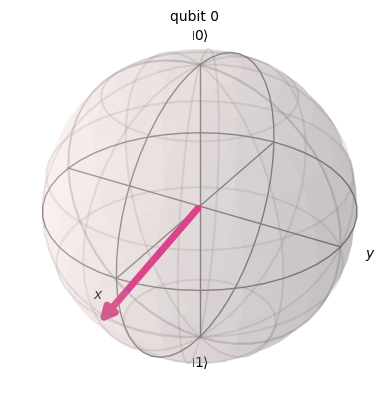

In [5]:
# View the circuit quantum state on the Bloch sphere 
out_qubit  = circuit

plot_bloch_multivector(out_qubit)
plt.show()

In [6]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
# circuit_simulator = AerSimulator()

In [7]:
# Copia del circuito para obtener el vector de estado final resultante
circuit2SV = circuit.copy()
circuit2SV.save_statevector()

In [8]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(circuit2SV, statevector_simulator)

# Run the circuit with the state vector simulator to obtain a noise-free fractal.
# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
out_statevector = result.get_statevector(circ_statevector)

display(array_to_latex(Statevector(out_statevector), prefix="\\ket{out_{statevector}} = "))

<IPython.core.display.Latex object>

In [9]:
# Probabilidades asociadas el vector de estado resultante
print(out_statevector.probabilities())

[0.17335926 0.82664074]


In [10]:
# Extract the first element of the state vector as z0 and the second element as z1.
z0 = out_statevector.data[0]
z1 = out_statevector.data[1]

print(z0, z1)

(0.4032814824381882-0.10355339059327401j) (0.6535820712792957-0.6320373543718439j)


In [11]:
# Goal: One complex number for the Julia set fractal. 
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    print("Pre z= ",z)
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

print("z= ",z)

# Define the size
size = 1000
heightsize = size
widthsize = size

Pre z=  (0.3980292057007836+0.2264687818789998j)
z=  (0.4+0.23j)


In [12]:
def julia_set(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):

    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m] 
        m[np.abs(z) > 2] = False
        div_time[m] = i
    return div_time

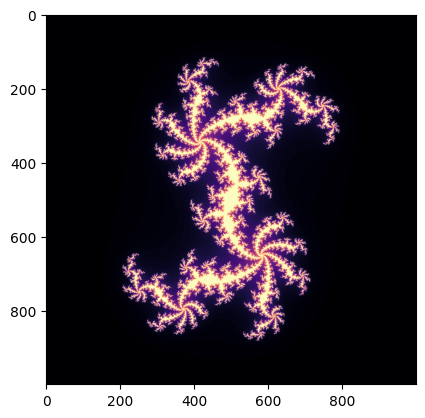

In [13]:
# plot the Julia set fractal
plt.imshow(julia_set(), cmap='magma') # viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.show()

# Running on a noise model-based on a real Quantum Computer

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
# from qiskit.transpiler import generate_preset_pass_manager

# The fake provider module contains fake providers and fake backends classes. 
# The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. 
# This allows to simulate a noise model generated from system snapshots obtained in the past.
# Here we choose a noise model based on an old backend named ibmq_Bogota of 5 qubits.
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2

In [15]:
service = QiskitRuntimeService()

# ibmq_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
ibmq_backend = FakeBogotaV2()

# print("The least busy quantum computer now is:", ibmq_backend.name)
print("Now the chosen quantum computer is:", ibmq_backend.name)

Now the chosen quantum computer is: fake_bogota


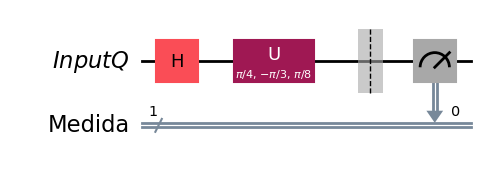

In [16]:
# Add measurement - used to calculate the modified state vector
circuit.barrier()
circuit.measure(InputQ, Medida)

circuit.draw('mpl', style="iqp")
plt.show()

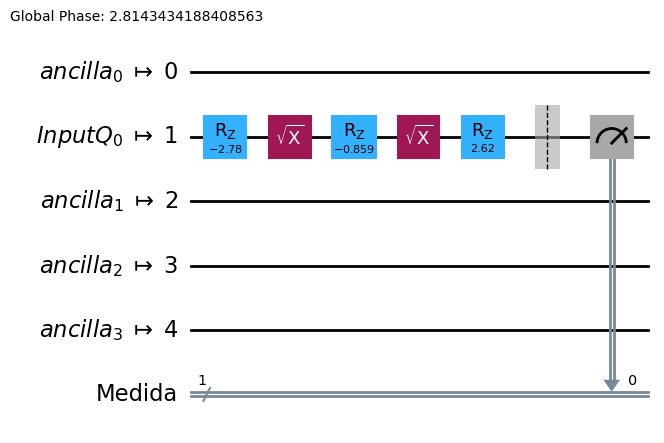

In [17]:
# Transpile the ideal circuit to a circuit that can be
# directly executed by the backend
transpiled_circuit = transpile(circuit, ibmq_backend)

transpiled_circuit.draw('mpl', style="iqp")
plt.show()

In [18]:
sampler2run = Sampler(mode=ibmq_backend)

# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job = sampler2run.run([transpiled_circuit], shots= shotno)

# ID del Job para rastrear la ejecución del circuito en tiempo real.
print(f">>> Job ID: {job.job_id()}")

# Consulta del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job ID: 58f50d46-8cb7-452f-b07d-1d70f7331410
>>> Job Status: JobStatus.RUNNING


In [19]:
# Nueva verificación del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.RUNNING


In [20]:
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]

# Get count measurement results
counts = pub_result.data.Medida.get_counts()

print(
    f"Counts for the 'meas' output register: {counts}"
)

Counts for the 'meas' output register: {'1': 827, '0': 197}


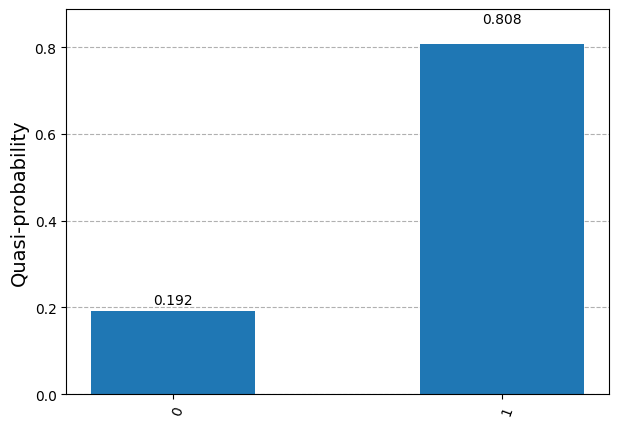

In [21]:
# Probabilidades de medición de cada salida, dada la ejecución real realizada.
plot_distribution(counts)

plt.show()

## Perform calculations and plot result

In [22]:
prob0qc = counts['0']/shotno
prob1qc = counts['1']/shotno
#print("Observed probabilities of measuring the computational basis states", round(prob0qc,3), round(prob1qc,3))

#print("Statevector: ", out)
#print("Statevector probilities of measuring the basis states: ", out.probabilities())
prob0statevec = out_statevector.probabilities()[0]
prob1statevec = out_statevector.probabilities()[1]

# one simple approach to calculate a quantum computer-modified complex number # amplitude^2 = probability
z0qc = z0*sqrt(prob0qc/prob0statevec)
z1qc = z1*sqrt(prob1qc/prob1statevec)
zqc = z0qc/z1qc
#zqcminus = -z0qc/z1qc
#print(z,zqc,zqcminus)

# compare the simulator state vector with the-running-on-a-real-quantum-computer modified state vector
print(z,zqc)

(0.4+0.23j) (0.42420929515332884+0.24136460581071964j)


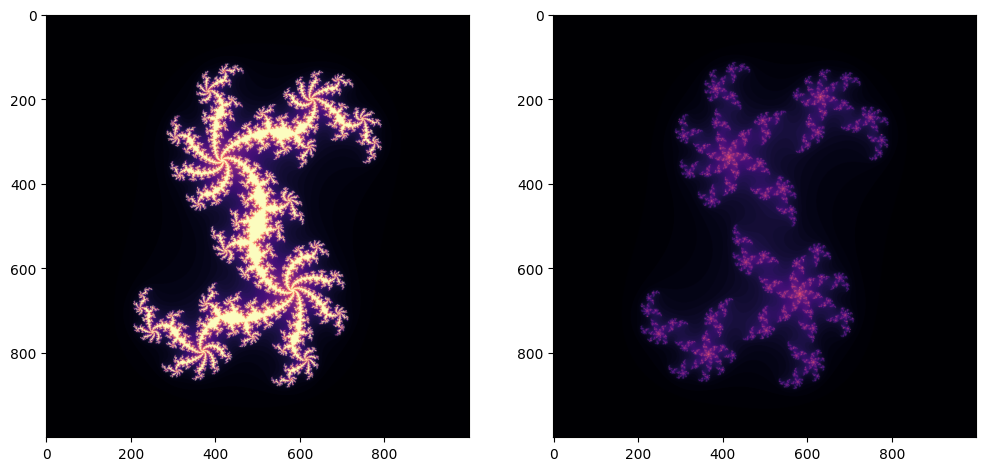

In [23]:
# Plot both Julia set fractals for comparison - the simulator based on the left and the modified on the right 
f, axarr = plt.subplots(1,2,figsize=(12, 12))
axarr[0].imshow(julia_set(c=z), cmap='magma')
axarr[1].imshow(julia_set(c=zqc), cmap='magma')

In [24]:
from qiskit import __version__
print(__version__)

1.3.2
